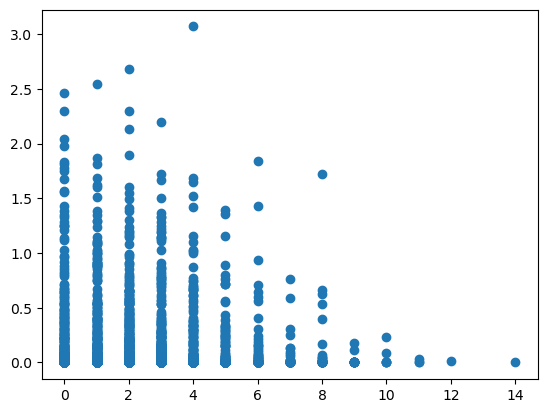

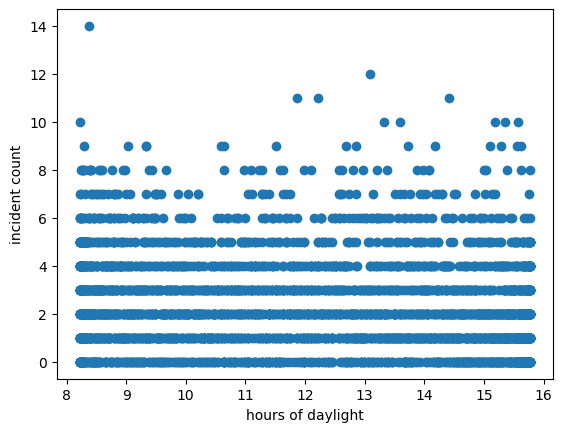

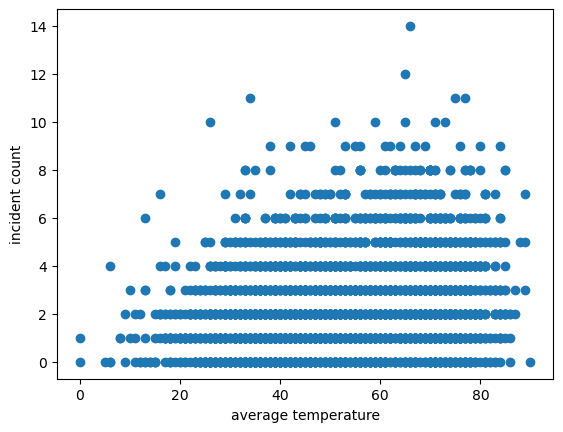

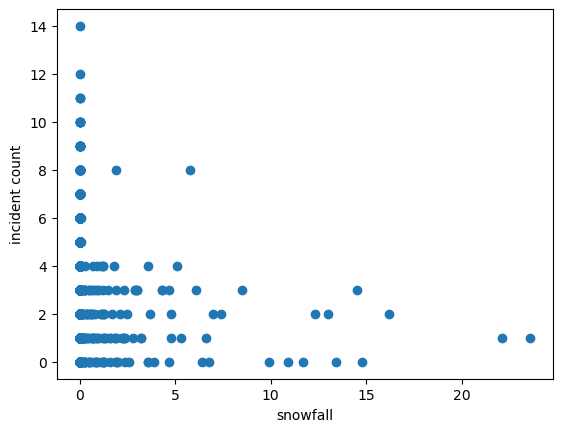

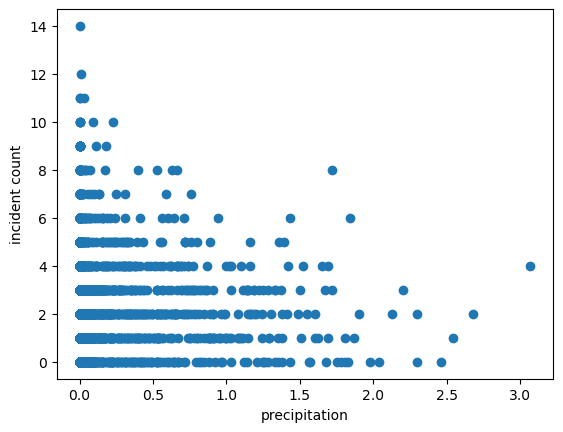

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

%run 'ShotsFired_EDA_aggregate_samples.ipynb'

In [2]:
# data lookin good
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours
0,2015-01-01,14.32,0.00,0.0,26,C11A15,False,2.0,12.587640
1,2015-01-02,12.75,0.00,0.0,34,B3E13,True,2.0,12.646087
2,2015-01-03,10.29,0.62,1.4,28,B2,False,1.0,12.704440
3,2015-01-04,8.28,0.57,0.0,38,B2B2,True,2.0,12.762693
4,2015-01-05,22.15,0.00,0.0,40,C6,False,1.0,12.820834


In [3]:
shot_count = 13

# let's rename all values: 10, 11, 12, 14 to 10+
shots_daily['incident_count'].replace([12, 14], '12.0', inplace=True)

# looking at value counts, this should be move to the EDA notebook soon
print(shots_daily['incident_count'].value_counts())

incident_count
2.0     721
1.0     712
3.0     542
0.0     465
4.0     361
5.0     219
6.0     122
7.0      61
8.0      42
9.0      15
10.0      6
11.0      3
12.0      2
Name: count, dtype: int64


In [4]:
# let's create X and y

X = shots_daily[['TAVG', 'PRCP', 'AWND', 'SNOW', 'daylight_hours']]
y = shots_daily['incident_count']

print(X.shape)
print(y.shape)

(3271, 5)
(3271,)


In [5]:
# let's split our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [6]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [7]:
y_train = tf.one_hot(y_train, depth=shot_count)
y_test = tf.one_hot(y_test, depth=shot_count)

In [8]:
# let's run a linear regression using keras

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(shot_count, activation='softmax')
])

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [10]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
)

callback_val_accuracy = keras.callbacks.EarlyStopping(
    monitor="vall_accuracy",
    patience=6,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0000
)

In [11]:
batch_size = 128
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    validation_split=0.1
                    )

Epoch 1/100


18/18 [==============================] - 0s 6ms/step - loss: 2.8453 - accuracy: 0.1812 - val_loss: 2.3499 - val_accuracy: 0.1463 - lr: 0.0100
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9797 - accuracy: 0.2102 - val_loss: 2.2171 - val_accuracy: 0.1707 - lr: 0.0100
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9625 - accuracy: 0.2256 - val_loss: 2.2380 - val_accuracy: 0.1626 - lr: 0.0100
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9558 - accuracy: 0.2275 - val_loss: 2.1738 - val_accuracy: 0.1748 - lr: 0.0100
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9550 - accuracy: 0.2279 - val_loss: 2.2469 - val_accuracy: 0.1870 - lr: 0.0100
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9555 - accuracy: 0.2338 - val_loss: 2.2165 - val_accuracy: 0.1789 - lr: 0.0100
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 1.9523 - accura

In [12]:
# let's evaluate our model

model.evaluate(X_test, y_test, verbose=2)

26/26 - 0s - loss: nan - accuracy: 0.2641 - 24ms/epoch - 928us/step


[nan, 0.2640586793422699]

In [13]:
# recording our results
# 3 labels: 55.3% accuracy
# 4 labels: 31.66% accuracy
# 5 labels: 22.13% accuracy
# 6 labels: 20.78% accuracy
# 7 labels: 26% accuracy
# 8 labels: 24.8% accuracy
# 9 labels: 24.9% accuracy
# 10 labels: 24.8% accuracy
# 11 labels: 25.18% accuracy
# 12 labels: 25.67% accuracy
# 13 labels: 25.41% accuracy


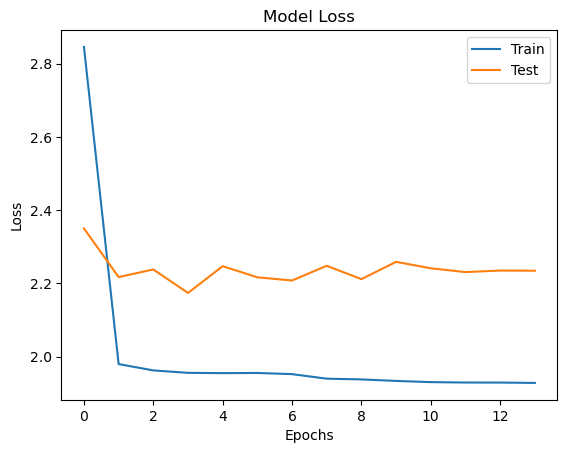

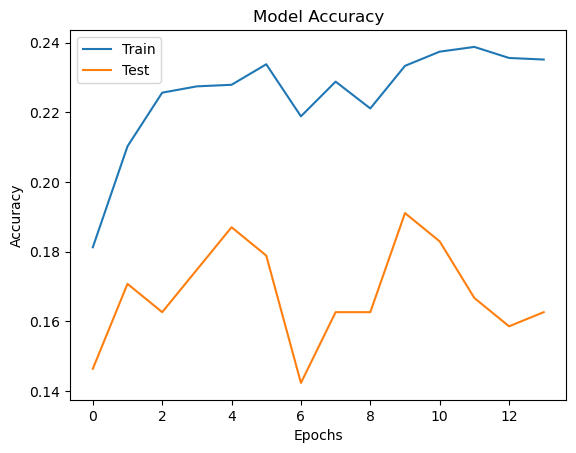

In [14]:
# let's plot our loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [15]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well